In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

In [2]:
def S21_from_ABCD(ABCD, Z0):
    A, B, C, D = ABCD[0, 0], ABCD[0, 1], ABCD[1, 0], ABCD[1, 1]
    return 2 / (A + B / Z0 + C * Z0 + D)

# Transmission line resonator without parasitic capacitance

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


Q_L =  15517.2188769


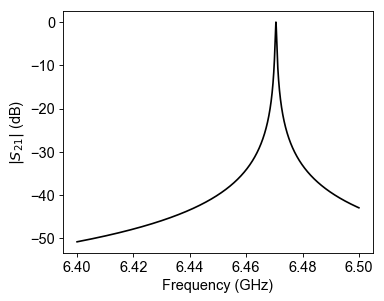

In [21]:
C_in = 3.5E-15 # Input capacitor, in Farad
C_out = 3.5E-15 # Output capacitor

Z0 = 50.
f0 = 6.5E9
c = 0.7 * 3.0E8
lamb0 = c / f0
l = lamb0 / 2.

f_d = np.linspace(6.4E9, 6.5E9, 1E5)
omega_d = 2 * np.pi * f_d

S21 = np.zeros(len(f_d), dtype=np.complex128)

for n, w_d in enumerate(omega_d): 
    lamb = 2 * np.pi * c / w_d
    beta = 2 * np.pi / lamb

    ABCD_C_in = np.array([[1, 1 / (1j * w_d * C_in)], 
                          [0, 1]])
    ABCD_C_out = np.array([[1, 1 / (1j * w_d * C_out)], 
                           [0, 1]])
    ABCD_trans = np.array([[np.cos(beta * l), 1j * Z0 * np.sin(beta * l)], 
                           [1j * np.sin(beta * l) / Z0, np.cos(beta * l)]])

    ABCD = np.dot(np.dot(ABCD_C_in, ABCD_trans), ABCD_C_out)
    
    S21[n] = S21_from_ABCD(ABCD, Z0)

fig = plt.figure(figsize=(5., 4.))
common.configure_axes(13)
plt.plot(f_d / 1e9, 20 * np.log10(np.abs(S21)), '-k')

center = f_d[np.argmax(np.abs(S21))]
fitspan = 50E6
fr, ferr = kfit.fit_lor(f_d, np.abs(S21) ** 2, domain=[center-fitspan/2., center+fitspan/2.], 
                        parambounds=[(-np.inf, -np.inf, -np.inf, 0), (np.inf, np.inf, np.inf, np.inf)], 
                        verbose=False)

# f_plot = np.linspace(center-fitspan/2., center+fitspan/2., 1E3)
# plt.plot(f_plot, 10 * np.log10(kfit.lorfunc(f_plot, *fr)), '-r', lw=2)
plt.xlabel("Frequency (GHz)")
plt.ylabel("$|S_{21}|$ (dB)")
print("Q_L = ", fr[2] / (2 * fr[3]))

The resonator quality factor matches the following formula quite well: 

$$Q_L \approx \frac{0.8}{(\omega_0 Z_0 C_\mathrm{in})^2}$$

In [22]:
2 * 1.6 / (2 * np.pi * f0 * Z0 * (C_in + C_out)) ** 2

15661.28668786286

# Transmission line resonator _with_ parasitic capacitance

Without parasitic capacitance: Q_L =  15517.2188769
With parasitic capacitance: Q_L =  12470.7407852


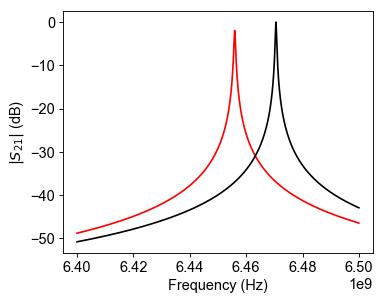

In [24]:
C_p = 0.5*C_in # Parasitic capacitance from the center pin to the DC electrodes which have Z_L
Z_L = 50. # Impedance of the DC bias lines

S21_parasitic = np.zeros(len(f_d), dtype=np.complex128)

for n, w_d in enumerate(omega_d): 
    lamb = 2 * np.pi * c / w_d
    beta = 2 * np.pi / lamb

    ABCD_C_p = np.array([[1, 0], 
                     [1 / (Z_L + 1 / (1j * w_d * C_p)), 1]])
    
    ABCD_C_in = np.array([[1, 1 / (1j * w_d * C_in)], 
                          [0, 1]])
    ABCD_C_out = np.array([[1, 1 / (1j * w_d * C_out)], 
                           [0, 1]])
    ABCD_trans = np.array([[np.cos(beta * l), 1j * Z0 * np.sin(beta * l)], 
                           [1j * np.sin(beta * l) / Z0, np.cos(beta * l)]])

    ABCD = np.dot(np.dot(np.dot(np.dot(ABCD_C_in, ABCD_C_p), ABCD_trans), ABCD_C_p), ABCD_C_out)
    
    S21_parasitic[n] = S21_from_ABCD(ABCD, Z0)

fig = plt.figure(figsize=(5., 4.))
common.configure_axes(13)
plt.plot(f_d, 20 * np.log10(np.abs(S21_parasitic)), '-r')
plt.plot(f_d, 20 * np.log10(np.abs(S21)), '-k')


center = f_d[np.argmax(np.abs(S21_parasitic))]
fitspan = 50E6
fr_p, ferr_p = kfit.fit_lor(f_d, np.abs(S21_parasitic) ** 2, domain=[center-fitspan/2., center+fitspan/2.], 
                        parambounds=[(-np.inf, -np.inf, -np.inf, 0), (np.inf, np.inf, np.inf, np.inf)], 
                        verbose=False)

# f_plot = np.linspace(center-fitspan/2., center+fitspan/2., 1E3)
# plt.plot(f_plot, 10 * np.log10(kfit.lorfunc(f_plot, *fr_p)), '-r', lw=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("$|S_{21}|$ (dB)")

print("Without parasitic capacitance: Q_L = ", fr[2] / (2 * fr[3]))
print("With parasitic capacitance: Q_L = ", fr_p[2] / (2 * fr_p[3]))

Can we make an estimate of how the parasitic capacitance affects the $Q$? We can make a guess and guess that it scales in the same way as the coupling $Q$. In that case: 
$$Q_i \approx \frac{1}{(\omega_0 Z_L C_p )^2}$$

In [25]:
Qc = 2 * 1.6 / (2 * np.pi * f0 * Z0 * (C_in + C_out)) ** 2
Qi = 0.8 / (2 * np.pi * f0 * Z_L * C_p) ** 2

print("Predicted Qc = ", Qc)
print("Predicted Qi = ", Qi)
print("Loaded Q would be QL = ", (1 / (1/Qc + 1/Qi)))

Predicted Qc =  15661.28668786286
Predicted Qi =  62645.14675145144
Loaded Q would be QL =  12529.029350290288


# Transmission line resonator _with_ parasitic capacitance _and_ filter

Without parasitic capacitance: Q_L =  15517.2188769
With parasitic capacitance: Q_L =  7830.19973637
With parasitic capacitance and filter: Q_L =  15608.7087396


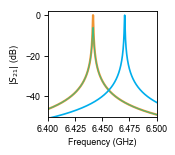

In [20]:
L_f = 2.5E-9 # Filter inductance in H
C_f = 4.0E-12 # Filter capacitance in F

S21_filter = np.zeros(len(f_d), dtype=np.complex128)

for n, w_d in enumerate(omega_d): 
    lamb = 2 * np.pi * c / w_d
    beta = 2 * np.pi / lamb

    ABCD_C_f = np.array([[1, 0], 
                         [1 / (1 / (1j * w_d * C_f + 1 / (1j * w_d * L_f + Z_L)) + 1 / (1j * w_d * C_p)), 1]])
    
    ABCD_C_in = np.array([[1, 1 / (1j * w_d * C_in)], 
                          [0, 1]])
    ABCD_C_out = np.array([[1, 1 / (1j * w_d * C_out)], 
                           [0, 1]])
    ABCD_trans = np.array([[np.cos(beta * l), 1j * Z0 * np.sin(beta * l)], 
                           [1j * np.sin(beta * l) / Z0, np.cos(beta * l)]])

    ABCD = np.dot(np.dot(np.dot(np.dot(ABCD_C_in, ABCD_C_f), ABCD_trans), ABCD_C_f), ABCD_C_out)
    
    S21_filter[n] = S21_from_ABCD(ABCD, Z0)

fig = plt.figure(figsize=(1.75, 1.75))
common.configure_axes(8)
plt.plot(f_d / 1e9, 20 * np.log10(np.abs(S21_filter)), '-', lw=2, color="#EF9332")
plt.plot(f_d / 1e9, 20 * np.log10(np.abs(S21_parasitic)), '-', lw=1 , color="#49B677")
plt.plot(f_d / 1e9, 20 * np.log10(np.abs(S21)), '-', color="#00AEEC")


center = f_d[np.argmax(np.abs(S21_filter))]
fitspan = 50E6
fr_f, ferr_f = kfit.fit_lor(f_d, np.abs(S21_filter) ** 2, domain=[center-fitspan/2., center+fitspan/2.], 
                        parambounds=[(-np.inf, -np.inf, -np.inf, 0), (np.inf, np.inf, np.inf, np.inf)], 
                        verbose=False)

# f_plot = np.linspace(center-fitspan/2., center+fitspan/2., 1E3)
# plt.plot(f_plot, 10 * np.log10(kfit.lorfunc(f_plot, *fr_p)), '-r', lw=2)
plt.xlabel("Frequency (GHz)")
plt.ylabel("$|S_{21}|$ (dB)")
plt.xlim(6.4, 6.5)
plt.ylim(-50, 2)

print("Without parasitic capacitance: Q_L = ", fr[2] / (2 * fr[3]))
print("With parasitic capacitance: Q_L = ", fr_p[2] / (2 * fr_p[3]))
print("With parasitic capacitance and filter: Q_L = ", fr_f[2] / (2 * fr_f[3]))

if 0:
    fig_dir = r"S:\Gerwin\Thesis\Figures"
    fig.savefig(os.path.join(fig_dir, "ParasiticCapacitanceWithFilter.pdf"), 
                dpi=300, bbox_inches='tight', pad_inches=0)